# Jupyter notebook to visualize our results after training PyTorch model

Please run this notebook from the notebooks directory.

Some useful links:
- https://brandonrozek.com/blog/jupyterwithpyenv/

- https://github.com/microsoft/vscode-jupyter/wiki/Setting-Up-Run-by-Line-and-Debugging-for-Notebooks

### Imports

In [1]:
!python --version

Python 3.10.6


In [2]:
import sys

sys.path.append('../')
sys.path.append('../src')

In [35]:
import gc
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import torch


from hydra import initialize, compose
from ipywidgets import interact, FloatSlider
from pathlib import Path
from src import *
from src.trainer import Trainer
from src.visualizer import plot_val_residual, plot_val_pull

### Load trained model & more

In [4]:
with initialize(version_base=None, config_path="../config"):
    cfg = compose(config_name='trainer.yaml')
    cfg.wandb.mode = "disabled"

    root_filename = "../" + cfg.dataset.filename

    # cfg.dataset.filename = root_filename
    # cfg.dataset.save_format = "pkl"
    
    # Comment prev. line and uncomment this below
    # once we're sure that we don't change anymore the dataset:
    p = Path(root_filename)
    filename =  f"{str(p.parent)}/{p.stem}_dataset.pkl"
    if Path(filename).is_file():  # if exists and is a file
        cfg.dataset.filename = filename
    else:
        cfg.dataset.filename = root_filename
        cfg.dataset.save_format = "pkl"  # to save dataset

    trainer = Trainer(cfg)

    ### Loading checkpoint
    general_checkpoint = torch.load("../checkpoints/last_general_checkpoint.pth")
    trainer.model.load_state_dict(general_checkpoint["model_state_dict"])
    trainer.optimizer.load_state_dict(general_checkpoint["optimizer_state_dict"])

    trainer.epoch = general_checkpoint["epoch"]
    trainer.train_loss = general_checkpoint["train_loss"]
    trainer.val_loss = general_checkpoint["val_loss"]
    
    trainer.model.eval()
    torch.set_grad_enabled(False)
    # it helps with memory-related issues:
    # https://stackoverflow.com/questions/69007342/disable-grad-and-backward-globally
    # https://discuss.pytorch.org/t/how-to-delete-a-tensor-in-gpu-to-free-up-memory/48879/15

[array([      0,       1,       2, ..., 3930742, 3930743, 3930744]), array([    250,     251,     506, ..., 3930363, 3930618, 3930619]), array([    252,     253,     508, ..., 3930365, 3930620, 3930621])]


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


In [5]:
trainer.dataset_full.data_df

,unix_time,glat,glon,altitude,temperature,fe_cosmic,corrected,correrr,config,raz,...,1/rate_err[6]**2,1/rate_err[10]**2,1/rate_err[12]**2,rate[0]/rate_err[0],rate[1]/rate_err[1],rate[5]/rate_err[5],rate[6]/rate_err[6],rate[10]/rate_err[10],rate[12]/rate_err[12],(unix_time-1474004181.5460)//5535.4+10
0,1.483525e+09,41.273513,64.930544,376.565432,33.500000,1177.0,1111.225454,0.0,42,335.977594,...,0.000364,0.000260,0.000270,28.621580,22.109620,54.603536,49.826243,58.944945,57.878622,1730.0
1,1.483525e+09,41.301336,65.091966,376.553905,33.500000,1185.0,1077.260702,0.0,42,336.125659,...,0.000348,0.000256,0.000257,27.929632,21.788451,54.791671,50.310019,58.843234,58.802215,1730.0
2,1.483525e+09,41.301336,65.091966,376.553905,33.500000,1185.0,1067.501924,0.0,42,336.125659,...,0.000348,0.000252,0.000253,27.636904,21.803819,54.403405,50.046106,58.948036,58.898361,1730.0
3,1.483525e+09,41.328899,65.253475,376.536191,33.500000,2154.0,1108.812904,0.0,42,336.273850,...,0.000343,0.000246,0.000247,28.166676,21.966212,55.363248,50.761011,60.010819,59.940325,1730.0
4,1.483525e+09,41.328899,65.253475,376.536191,33.500000,2154.0,1110.524550,0.0,42,336.273850,...,0.000349,0.000251,0.000252,28.515913,22.481051,55.182131,50.641369,59.763522,59.708677,1730.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3956641,1.489745e+09,-42.757777,126.189354,386.590141,34.400002,24460.0,1946.386405,0.0,42,91.466481,...,0.000197,0.000132,0.000132,39.073977,29.911732,73.389050,66.531368,80.931946,80.931946,2853.0
3956642,1.489745e+09,-42.758912,126.358379,386.578593,34.400002,24778.0,2020.254206,0.0,42,91.614903,...,0.000191,0.000130,0.000130,40.109691,31.212337,74.295432,67.827269,81.857269,81.857269,2853.0
3956643,1.489745e+09,-42.758912,126.358379,386.578593,34.400002,24778.0,1960.692600,0.0,42,91.614903,...,0.000197,0.000133,0.000133,39.401131,30.389685,73.269094,66.799552,81.149886,81.139297,2853.0
3956644,1.489745e+09,-42.759779,126.527354,386.562382,34.400002,24223.0,2001.103329,0.0,42,91.763169,...,0.000202,0.000133,0.000133,39.691491,30.651826,72.450085,65.728584,80.722957,80.711165,2853.0


### Recreate dataset that includes the GRBs we've removed

In [6]:
# init trainer with a dataset that doesn't filter out the
# GRBs -> we only use it to obtain the dataset with GRBs
# may take some time as it recreates the dataset
cfg.dataset.filename = root_filename
cfg.dataset.save_format = None
cfg.dataset.filter_conditions = ["rate[0]/rate_err[0] > 20"]
trainer_with_GRBs = Trainer(cfg)
dataset_full_GRBs = trainer_with_GRBs.dataset_full

<string>:1: RuntimeWarning: divide by zero encountered in divide
<string>:1: RuntimeWarning: invalid value encountered in divide


[array([      0,       1,       2, ..., 3935515, 3935516, 3935517]), array([    250,     251,     506, ..., 3935227, 3935482, 3935483]), array([    252,     253,     508, ..., 3935229, 3935484, 3935485])]


In [7]:
from torch.utils.data import Subset
## Prediction on full dataset with GRBs (e.g rate[0])
# Need to transform before inputting the whole set into
# the model
X = dataset_full_GRBs.X_cpu
dataset_tensor = dataset_full_GRBs.transform(X).to(device=cfg.common.device)

pred = trainer.model(dataset_tensor).detach().to("cpu")  # apply the model trained without GRBs on
# whole dataset including GRBs.

dataset_tensor = dataset_tensor.to(device="cpu")
del dataset_tensor
torch.cuda.empty_cache()
gc.collect()

# Create a PyTorch Subset with all data
data_df = dataset_full_GRBs.data_df
subset_dataset_full_GRBs = Subset(dataset_full_GRBs,
                                  indices=range(dataset_full_GRBs.n_examples))

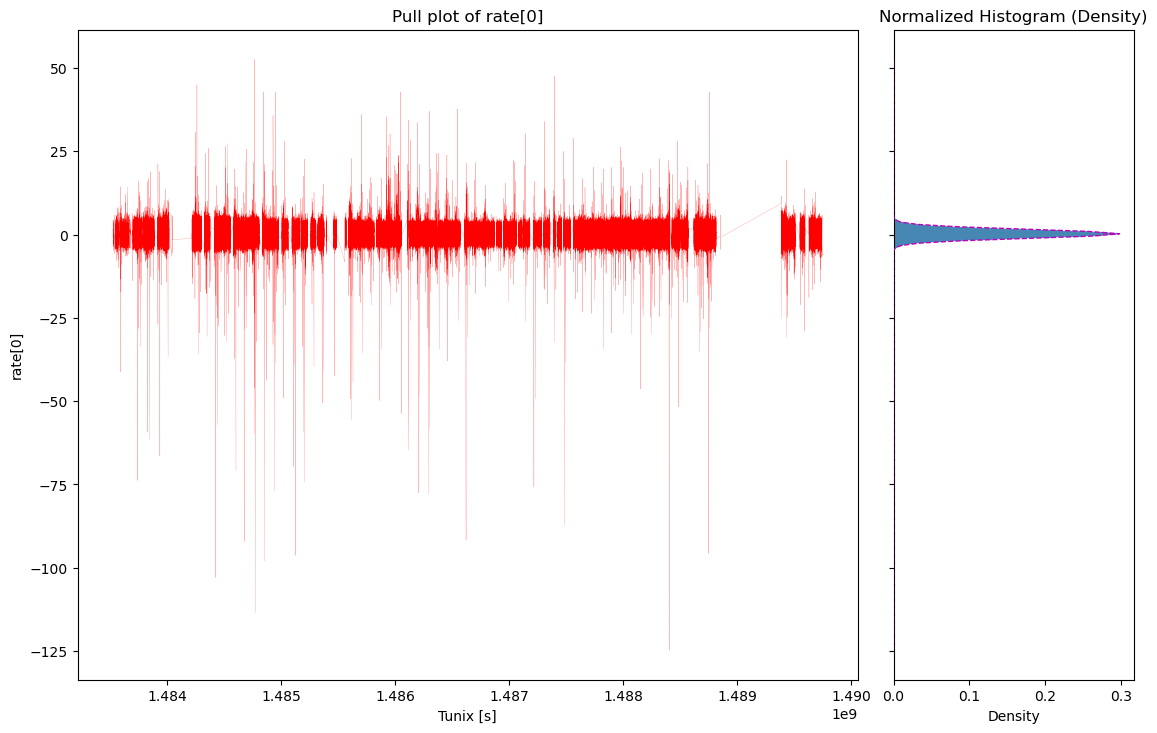

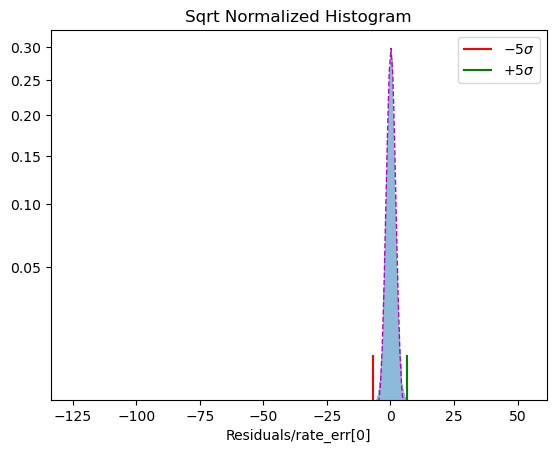

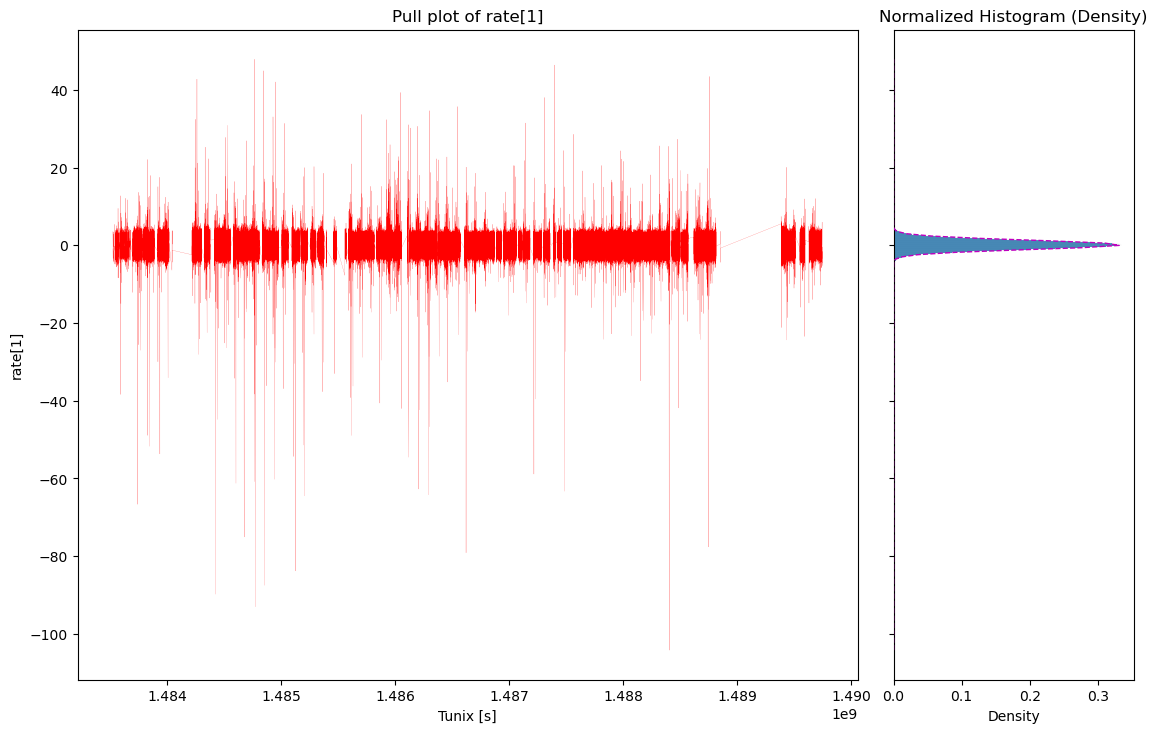

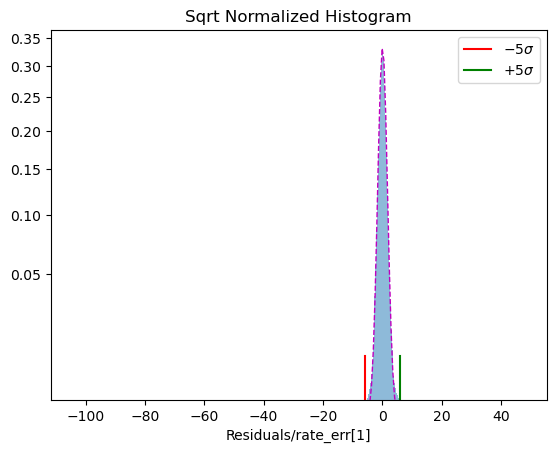

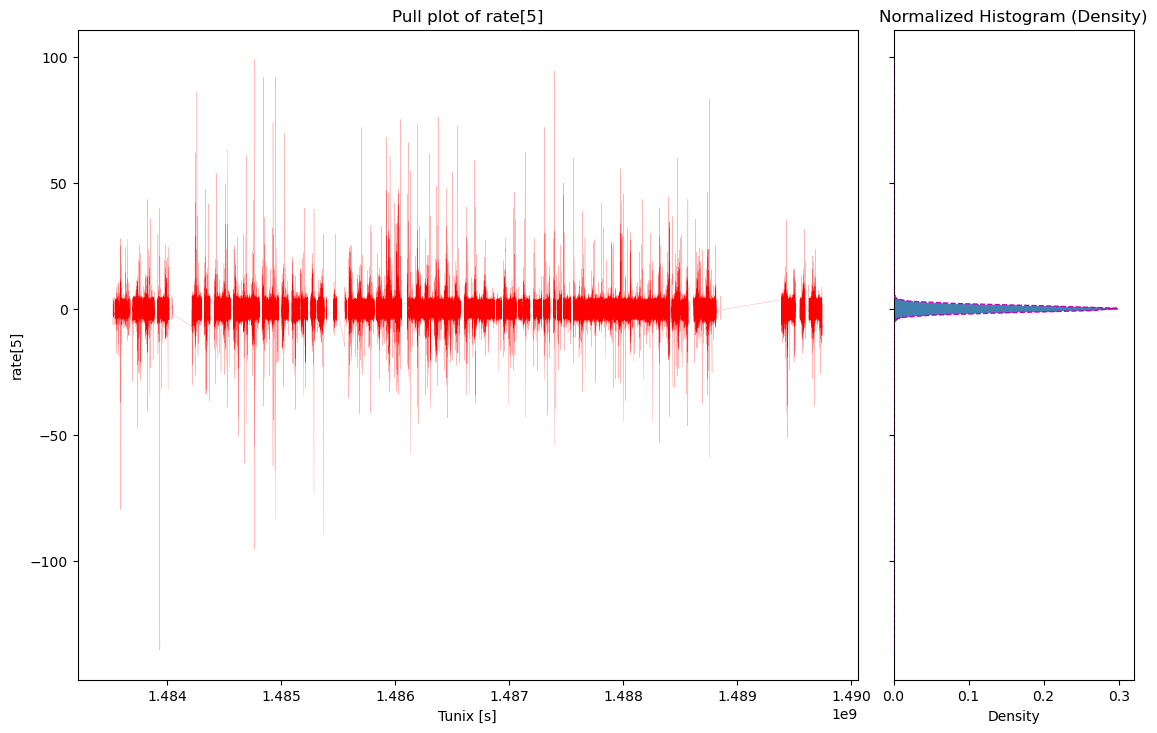

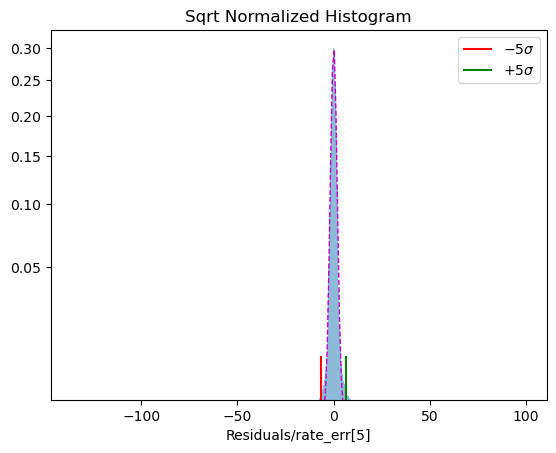

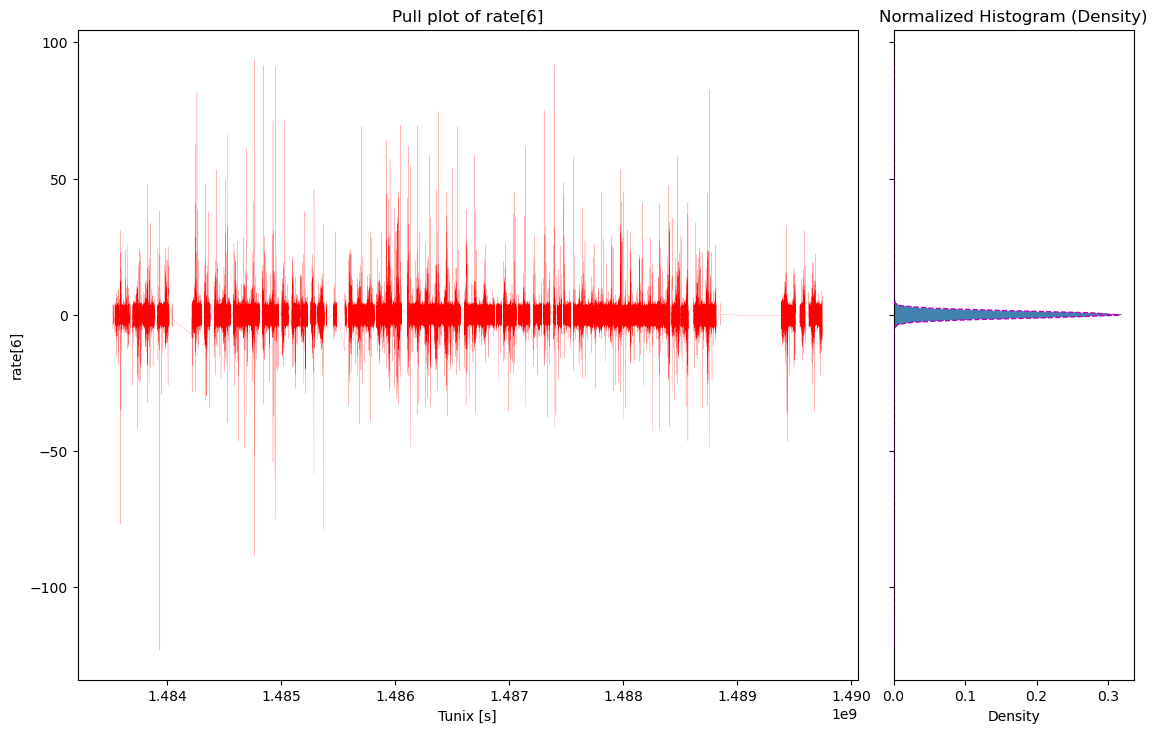

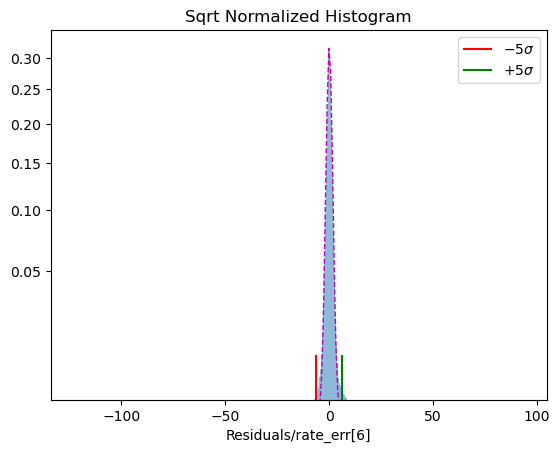

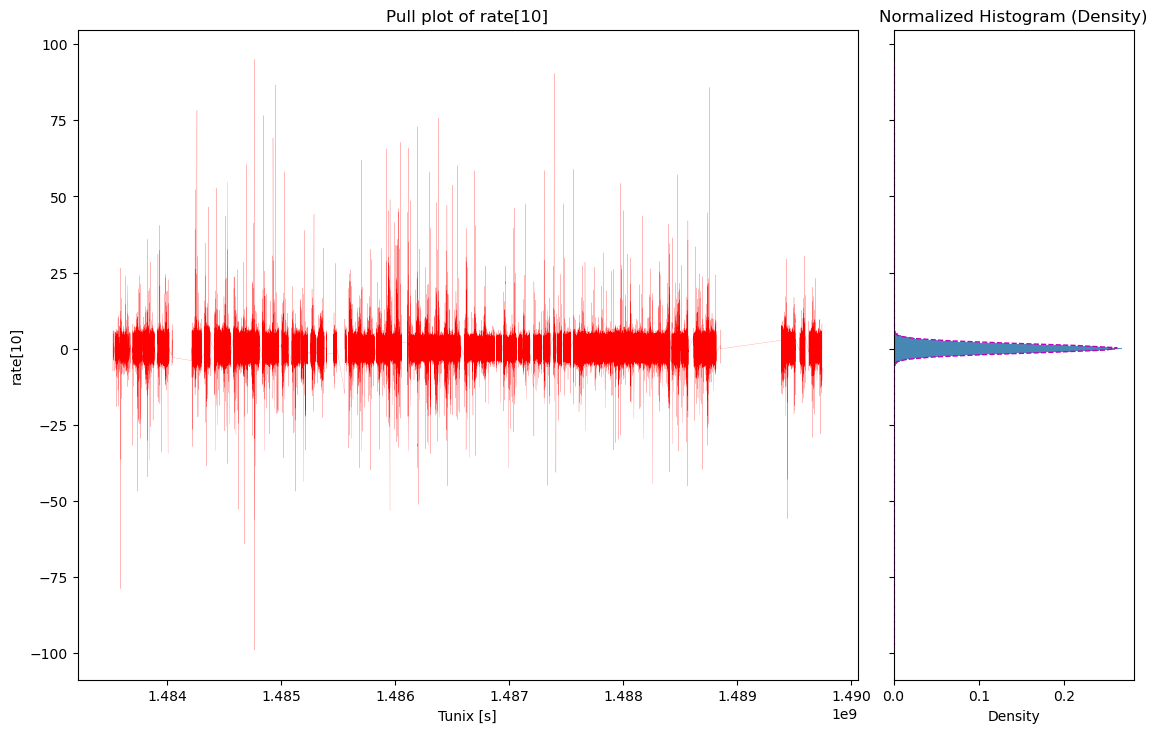

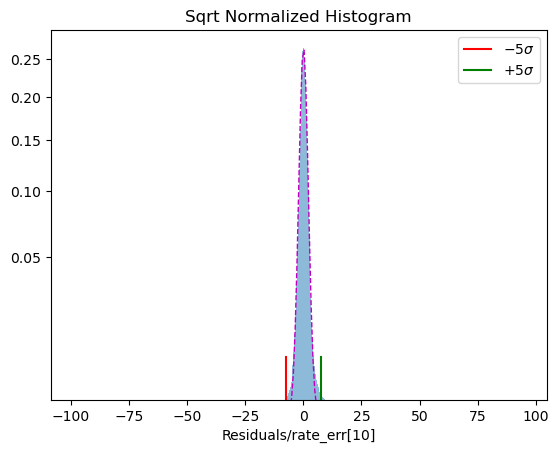

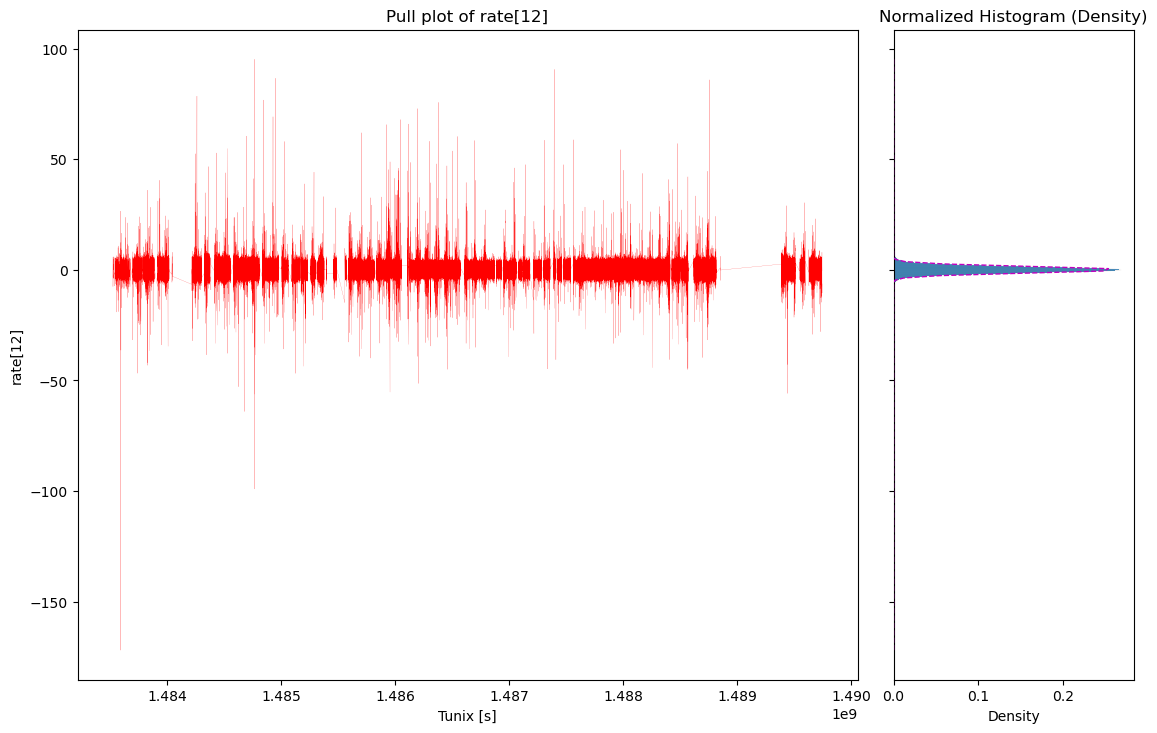

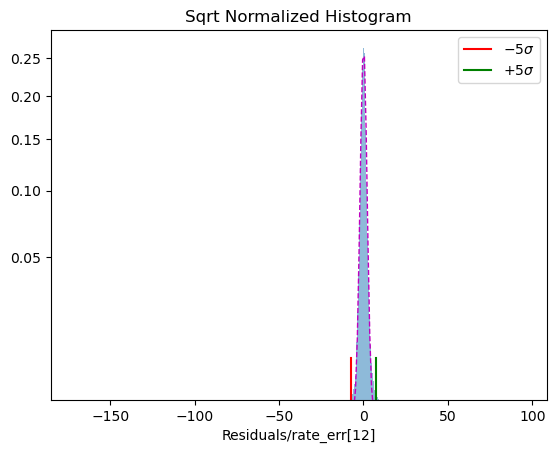

In [8]:
with plt.ioff():
    rate_err_names = []
    gcfs = []
    target_id_dict = {target_name: i for i, target_name in enumerate(cfg.dataset.target_names)}
    for target_name, i in target_id_dict.items():
        # Even though we call the function that has as name "plot_val_residual"
        # we apply it to the whole dataset including GRBs
        if target_name not in [f"rate[{i}]" for i in range(13)]:
            fig, fig2 = plot_val_residual(subset_dataset_full_GRBs,
                            pred,
                            target_name=target_name,
                            save_path=None,
                            save_path_hist=None)
        else:
            # rate[i] != rate[j]
            j = re.findall("[0-9]+", target_name)[0]
            rate_err_names.append(f"rate_err[{j}]")
            fig, fig2 = plot_val_pull(subset_dataset_full_GRBs,
                        pred,
                        target_name=target_name,
                        rate_err_name=rate_err_names[-1],
                        save_path=None,
                        save_path_hist=None)
        gcfs += [fig, fig2]

plt.show()

Interactive plot using ipywidgets. See these links:
-  https://stackoverflow.com/questions/72271574/interactive-plot-of-dataframe-by-index-with-ipywidgets
- https://ipywidgets.readthedocs.io/en/stable/examples/Using%20Interact.html

In [9]:
@interact(target_name=list(cfg.dataset.target_names))
def residual_plot(target_name):
    return gcfs[2*target_id_dict[target_name]]

interactive(children=(Dropdown(description='target_name', options=('rate[0]', 'rate[1]', 'rate[5]', 'rate[6]',…

In [10]:
@interact(target_name=list(cfg.dataset.target_names))
def residual_hist(target_name):
    return gcfs[2*target_id_dict[target_name]+1]

interactive(children=(Dropdown(description='target_name', options=('rate[0]', 'rate[1]', 'rate[5]', 'rate[6]',…

In [11]:
from src.visualizer import get_all_time_y_y_hat, find_moments, get_columns

tmp = get_all_time_y_y_hat(subset_dataset_full_GRBs, pred)
sorted_time, sorted_y, sorted_y_hat = tmp
del tmp


residuals = sorted_y-sorted_y_hat
var = residuals

tmp = np.isin(cfg.dataset.target_names, [f"rate[{i}]" for i in range(13)])

if ~np.any(tmp):
    print(f"Thresholding using residuals")
    new_mean, new_std = list(zip(*[find_moments(residuals[:, j])\
                                   for j in range(residuals.shape[1])]))
    new_mean, new_std = np.array(new_mean), np.array(new_std)
elif np.all(tmp):
    print("Thresholding using residuals/rate_errs (pull)")
    rate_errs = get_columns(subset_dataset_full_GRBs, rate_err_names)
    pulls = residuals/rate_errs
    new_mean, new_std = list(zip(*[find_moments(pulls[:, j])\
                                   for j in range(pulls.shape[1])]))
    new_mean, new_std = np.array(new_mean), np.array(new_std)
    var = pulls
else:
    raise NotImplementedError("Did not implement the case in which the targets are a mix of rate[i] and other")
del tmp

k = 3
print(np.sum(var > k*new_std, axis=0))    

Thresholding using residuals/rate_errs (pull)
[30162 27274 55660 55011 48230 48520]


In [12]:
new_std

array([1.3375583, 1.196147 , 1.3169341, 1.2481014, 1.5024753, 1.4970227],
      dtype=float32)

In [42]:
@interact(target_name=list(cfg.dataset.target_names),
          k=FloatSlider(value=k, min=1, max=5, step=0.5, continuous_update=False))
def red_points(target_name, k):
    id = target_id_dict[target_name]
    plt.plot(data_df["unix_time"], data_df[target_name],
         linewidth=0.05, label="whole data")

    plt.scatter(data_df.loc[var[:, id] > k*new_std[id], "unix_time"],
            data_df.loc[var[:, id] > k*new_std[id], target_name],
            color='r', label=fr"data s.t var > ${k}\sigma$")
    plt.title(fr"Data for which the var > ${k}\sigma$, $\sigma\approx{new_std[id]:.4f}$")
    plt.legend()
    plt.show()

interactive(children=(Dropdown(description='target_name', options=('rate[0]', 'rate[1]', 'rate[5]', 'rate[6]',…

### GRBs

In [14]:
GRBs = pd.read_csv("../data/GRBs.csv")

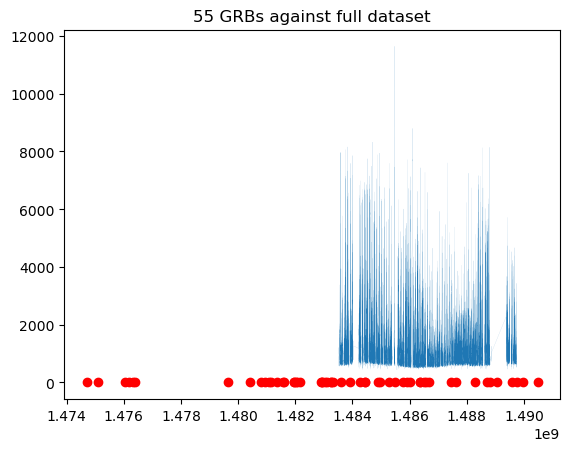

In [15]:
# Showing for the first target
plt.plot(data_df["unix_time"], data_df[cfg.dataset.target_names[0]], linewidth=0.05)
plt.scatter(GRBs["unix_time"], np.zeros_like(GRBs["unix_time"]), color="r")
plt.title("55 GRBs against full dataset")
plt.show()

Let's only take a look at the GRBs happening within the same time range

In [16]:
mask = data_df["unix_time"].min() <= GRBs["unix_time"].values
mask &= GRBs["unix_time"].values <= data_df["unix_time"].max()
print(f"Out of 55, there are: {mask.sum()} GRBs within our time range")

Out of 55, there are: 25 GRBs within our time range


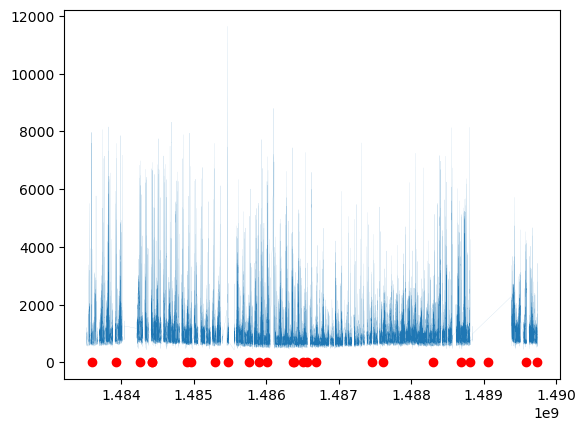

In [17]:
# Showing for the first target
plt.plot(data_df["unix_time"], data_df[cfg.dataset.target_names[0]], linewidth=0.05)
plt.scatter(GRBs["unix_time"][mask], np.zeros_like(GRBs["unix_time"][mask]), color="r")
plt.show()

Zooming into the GRBs with a window of 100 seconds before and 100 seconds after

In [41]:
@interact(target_name=list(cfg.dataset.target_names),
          k=FloatSlider(value=k, min=1, max=5, step=0.5, continuous_update=False))
def show_grbs(target_name, k):
     # Show 25 GRBs as well as our predictions and the red points
     # that are those > k*std
     w = 100
     id = target_id_dict[target_name]

     fig, axs = plt.subplots(5, 5, figsize=(10, 12), sharey=True)
     for i, GRB_name, GRB_tunix in zip(range(mask.sum()),
                         GRBs["GRB_Name"][mask],
                         GRBs["unix_time"][mask]):
          m = data_df["unix_time"] >= GRB_tunix-w
          m &= data_df["unix_time"] <= GRB_tunix+w
          m = m.values

          mvar = data_df["unix_time"] >= GRB_tunix-w
          mvar &= data_df["unix_time"] <= GRB_tunix+w
          mvar &= (var[:, id] > k*new_std[id])
          if m.sum() > 0:
               axs[i//5, i%5].plot(data_df[m]["unix_time"],
                         data_df[m][target_name], linewidth=0.4)
               axs[i//5, i%5].plot(data_df[m]["unix_time"],
                                   pred[:, id][m], 'orange', linewidth=0.4)
               axs[i//5, i%5].vlines(GRB_tunix, 0,
                                   data_df[m][target_name].max(),
                                   'r', linewidth=0.1)
               axs[i//5, i%5].set_title(GRB_name)
          if mvar.sum() > 0:
               axs[i//5, i%5].scatter(data_df.loc[mvar, "unix_time"],
                    data_df.loc[mvar, target_name],
                    color='r', label=fr"data s.t var > ${k}\sigma$")
     plt.tight_layout()
     plt.show()

interactive(children=(Dropdown(description='target_name', options=('rate[0]', 'rate[1]', 'rate[5]', 'rate[6]',…

Looking at the residuals or pulls

In [43]:
@interact(target_name=list(cfg.dataset.target_names),
          k=FloatSlider(value=k, min=1, max=5, step=0.5, continuous_update=False))
def show_var(target_name, k):
     id = target_id_dict[target_name]

     fig, axs = plt.subplots(5, 5, figsize=(10, 12), sharey=True)
     for i, GRB_name, GRB_tunix in zip(range(mask.sum()),
                         GRBs["GRB_Name"][mask],
                         GRBs["unix_time"][mask]):
          m = data_df["unix_time"] >= GRB_tunix-w
          m &= data_df["unix_time"] <= GRB_tunix+w
          m = m.values

          mvar = data_df["unix_time"] >= GRB_tunix-w
          mvar &= data_df["unix_time"] <= GRB_tunix+w
          mvar &= (var[:, id] > k*new_std[id])
          if m.sum() > 0:
               axs[i//5, i%5].plot(data_df[m]["unix_time"],
                                   var[:, id][m], 'k', linewidth=0.4)
               axs[i//5, i%5].vlines(GRB_tunix, 0,
                                   var[:, id][m].max(),
                                   'r', linewidth=0.1)
               axs[i//5, i%5].set_title(GRB_name)
          if mvar.sum() > 0:
               axs[i//5, i%5].scatter(data_df.loc[mvar, "unix_time"],
                                   var[:, id][mvar],
                                   color='r', label=fr"data s.t var > ${k}\sigma$")
     plt.tight_layout()
     plt.show()

interactive(children=(Dropdown(description='target_name', options=('rate[0]', 'rate[1]', 'rate[5]', 'rate[6]',…

### Clusters

In [47]:
@interact(target_name=list(cfg.dataset.target_names),
          k=FloatSlider(value=k, min=1, max=5, step=0.5, continuous_update=False))
def plot_clusters(target_name, k):
    id = target_id_dict[target_name]

    # Red points of interest
    points = data_df.loc[(var[:, id] > k*new_std[id]), "unix_time"]
    points = points.reset_index(drop=True)

    delta = (points.values[1:]-points.values[:-1]).astype(int)
    delta = np.concatenate([np.array([np.inf]), delta])

    starts = points.loc[delta > 1]

    # idx_ends not just starts.index.values[1:] as it would take way
    # too big ranges due to delta > 1
    idx_ends = starts.index.values[1:] - 1
    idx_ends = np.concatenate([idx_ends, [points.size-1]])  # include last data point

    ends = points.iloc[idx_ends]

    # Adding a label to each group/cluster
    idx_starts = starts.index.values
    groups = np.repeat(np.arange(len(idx_starts))+1, idx_ends - idx_starts + 1)
    import warnings
    warnings.filterwarnings("ignore")
    data = data_df.loc[(var[:, id] > k*new_std[id])]
    data["group"] = groups
    warnings.filterwarnings("default")
    

    integral = data.groupby("group")["rate[0]"].sum().values
    lengths = ends.values-starts.values

    plt.plot(lengths, integral, '.')
    plt.xlabel("Length [s]")
    plt.ylabel("Integral [Hz]")
    plt.grid("on")
    plt.show()

### Step-by-step creating the clusters

In [20]:
# Red points of interest
points = data_df.loc[(var[:, 0] > k*new_std[0]), "unix_time"]
points = points.reset_index(drop=True)
points

0        1.483526e+09
1        1.483526e+09
2        1.483528e+09
3        1.483542e+09
4        1.483542e+09
             ...     
30157    1.489744e+09
30158    1.489745e+09
30159    1.489745e+09
30160    1.489745e+09
30161    1.489745e+09
Name: unix_time, Length: 30162, dtype: float64

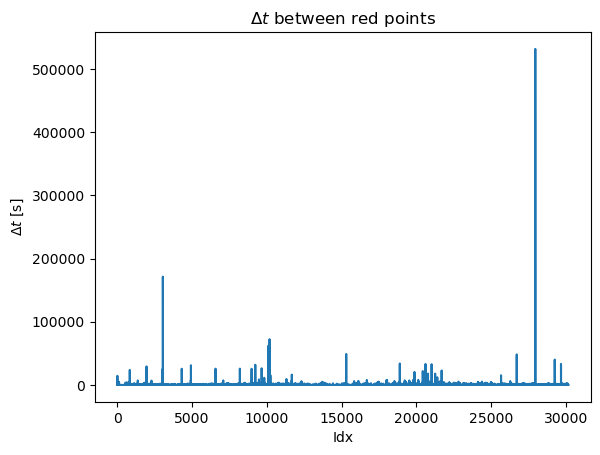

In [21]:
plt.plot(points.values[1:]-points.values[:-1])
plt.title(r"$\Delta t$ between red points")
plt.xlabel("Idx")
plt.ylabel(r"$\Delta t$ [s]")
plt.show()

We can use them to determine "begin and end" of clusters. Note that the huge spike on the right is due to the missing data.

In [22]:
delta = (points.values[1:]-points.values[:-1]).astype(int)
delta = np.concatenate([np.array([np.inf]), delta])

starts = points.loc[delta > 1]
print(starts.shape)

# idx_ends not just starts.index.values[1:] as it would take way
# too big ranges due to delta > 1
idx_ends = starts.index.values[1:] - 1
idx_ends = np.concatenate([idx_ends, [points.size-1]])  # include last data point

ends = points.iloc[idx_ends]
print(ends.shape)

(18182,)
(18182,)


The length of `starts` or `ends` indicates the number of clusters.

Adding a label to each group/cluster:

In [23]:
idx_starts = starts.index.values
groups = np.repeat(np.arange(len(idx_starts))+1, idx_ends - idx_starts + 1)
groups[:100]


array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 14, 15, 16,
       17, 18, 19, 20, 20, 21, 22, 22, 23, 23, 24, 24, 24, 24, 25, 26, 26,
       26, 27, 28, 28, 28, 28, 28, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37,
       38, 39, 40, 41, 42, 43, 44, 45, 46, 46, 46, 46, 46, 46, 47, 48, 48,
       49, 50, 50, 50, 51, 52, 52, 53, 54, 54, 55, 56, 57, 58, 59, 60, 61,
       62, 63, 64, 65, 66, 67, 68, 68, 68, 68, 69, 70, 71, 72, 73])

In [24]:
data = data_df.loc[(var[:, 0] > k*new_std[0])]
data["group"] = groups

/tmp/ipykernel_2800198/1117862665.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["group"] = groups


In [25]:
integral = data.groupby("group")["rate[0]"].sum().values


Here is the length of the clusters in time duration (seconds):

In [26]:
lengths = ends.values-starts.values
lengths

array([0.        , 0.        , 0.        , ..., 0.        , 0.        ,
       1.00000334])

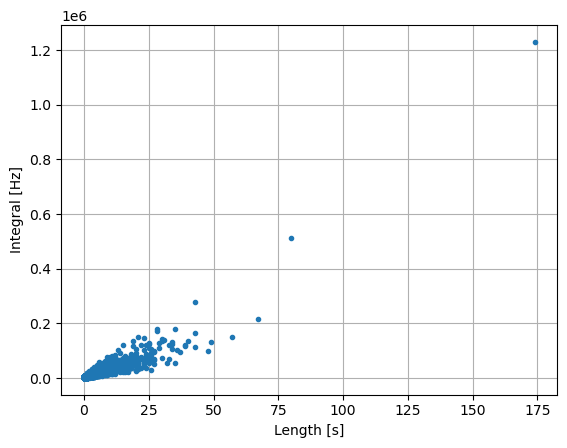

In [27]:
plt.plot(lengths, integral, '.')
plt.xlabel("Length [s]")
plt.ylabel("Integral [Hz]")
plt.grid("on")
plt.show()

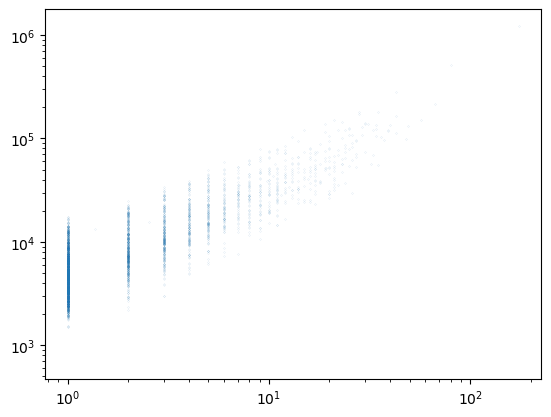

In [28]:
plt.loglog(lengths, integral, '.', markersize=0.1)
plt.show()

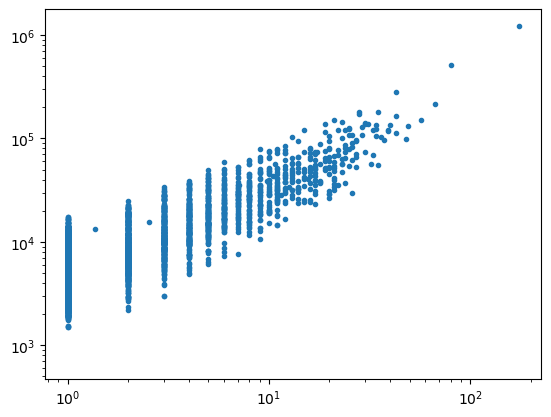

In [29]:
plt.loglog(lengths[integral > 5], integral[integral > 5], '.')
plt.show()